In [ ]:
%pylab inline
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
import re
import requests
from bs4 import BeautifulSoup
import datetime
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


# Анализ данных по подтверждённым случаям заболевания, выздоровления и смерти от COVID-19

##Загрузка и предобработка данных

В качестве рассматриваемого набора данных был выбран временной ряд о количестве подтверждённых случаев заражения, смерти и выздоровления от COVID-19 в разных странах за период 22.01.2020 – 16.04.2022. В качестве рассматриваемой страны была выбрана США ввиду большого объёма данных

In [ ]:
url = 'https://coronavirus-graph.ru/ssha'
page = requests.get(url)

In [ ]:
soup = BeautifulSoup(page.text, 'lxml')
table = soup.find('table', id='stat_table')

In [ ]:
headers = []
for th in table.find_all('th'):
  title = th.text
  headers.append(title)
headers[0], headers[2] = "Date", "Deaths"
dataframe = pd.DataFrame(columns = headers)

In [ ]:
dataframe

Empty DataFrame
Columns: [Date, Заражений всего, Deaths, Летальность, Выздоровело всего, Болеющих]
Index: []

In [ ]:
#22.01.2020 - первый день
current_day = 7
current_month = 4
current_year = 2023

for j in table.find_all('tr')[1:]:
  row_data = j.find_all('td')
  row = [i for i in row_data]
  
  if current_day == 1 and current_month - 1 in [1, 3, 5, 7, 8, 10, 12]:
    current_day = 31
    current_month -= 1
  elif current_day == 1 and current_month - 1 in [4, 6, 9, 11]:
    current_day = 30
    current_month -= 1
  elif current_day == 1 and current_month - 1 == 2:
    current_day = 28
    current_month -= 1
  elif current_day == 1 and current_month - 1 == 2 and current_year % 4 == 0:
    current_day = 29
    current_month -= 1
  else:
    current_day -= 1
    if current_month == 1 and current_day == 0:
      current_month = 12
      current_day = 31
      current_year -= 1
    

  if current_day == 10 and current_month == 3 and current_year == 2020:
    break


  length = len(dataframe)
  dataframe.loc[length] = row
  finded_deaths = re.search("(?<=<sup>)(.*?)(?=</sup>)", str(row[2]))

  date_time_str = f'{current_year}-{current_month}-{current_day}'
  date_time_obj = datetime.datetime.strptime(date_time_str, '%Y-%m-%d')
  dataframe.loc[length][0] = date_time_obj.date()
  if finded_deaths:
    dataframe.loc[length][2] = abs(int(finded_deaths.group(0)))
  else:
    dataframe.loc[length][2] = 0
dataframe

Date         Заражений всего Deaths Летальность  \
0     2023-04-06           [[106305779]]      0         [—]   
1     2023-04-05  [[106305779], [32088]]    632     [0.06%]   
2     2023-04-04  [[106273691], [20343]]    312     [0.03%]   
3     2023-04-03   [[106253348], [3600]]     33        [0%]   
4     2023-04-02  [[106249748], [27543]]    225     [0.02%]   
...          ...                     ...    ...         ...   
1117  2020-03-15         [[2727], [548]]      7     [0.26%]   
1118  2020-03-14         [[2179], [516]]      7     [0.33%]   
1119  2020-03-13         [[1663], [382]]      4     [0.25%]   
1120  2020-03-12         [[1281], [322]]      8     [0.65%]   
1121  2020-03-11          [[959], [376]]      6     [0.65%]   

           Выздоровело всего                      Болеющих  
0              [[104088992]]            [[ ], [1 060 487]]  
1     [[104088992], [33210]]   [[➜], [1 060 487], [-1754]]  
2     [[104055782], [23965]]   [[➜], [1 062 241], [-3934]]  
3     [[104031817], [18798]]  [[➜], [1 066 175], [-15231]]  
4      [[104013019], [7855]]  [[➜], [1 081 406], [+19463]]  
...                      ...                           ...  
1117                  [[12]]         [[➜], [2661], [+541]]  
1118                  [[12]]         [[➜], [2120], [+509]]  
1119             [[12], [4]]         [[➜], [1611], [+374]]  
1120                   [[8]]         [[➜], [1237], [+314]]  
1121              [[8], [1]]          [[➜], [923], [+369]]  

[1122 rows x 6 columns]

In [ ]:
headers.remove('Date')
headers.remove('Deaths')

In [ ]:
dataframe = dataframe.drop(dataframe.index[0])
dataframe = dataframe.drop(columns = headers)
dataframe

Date Deaths
1     2023-04-05    632
2     2023-04-04    312
3     2023-04-03     33
4     2023-04-02    225
5     2023-04-01     29
...          ...    ...
1117  2020-03-15      7
1118  2020-03-14      7
1119  2020-03-13      4
1120  2020-03-12      8
1121  2020-03-11      6

[1121 rows x 2 columns]

In [ ]:
dataframe.to_csv("covid19_deaths_USA.csv")

In [ ]:
dataframe = pd.read_csv('covid19_deaths_USA.csv', dayfirst = True, index_col = "Date", parse_dates = ['Date'])
dataframe = dataframe.drop(columns="Unnamed: 0")
dataframe

Deaths
Date              
2023-04-05     632
2023-04-04     312
2023-04-03      33
2023-04-02     225
2023-04-01      29
...            ...
2020-03-15       7
2020-03-14       7
2020-03-13       4
2020-03-12       8
2020-03-11       6

[1121 rows x 1 columns]

Временной ряд позволяет работать с несколькими значениями:
- Число заразившихся
- Число исцелившихся
- Число умерших

В качестве рассматриваемого значения было выбрано количество умерших людей

##Изучение временного ряда

Следует учитывать, что статистика о количестве смертей заносилась на сайт вручную, могут иметься опечатки и неточности. На данном этапе будут применены различного рода мероприятия для "причёсывания" набора данных

Text(0, 0.5, 'Death from COVID-19 in USA')

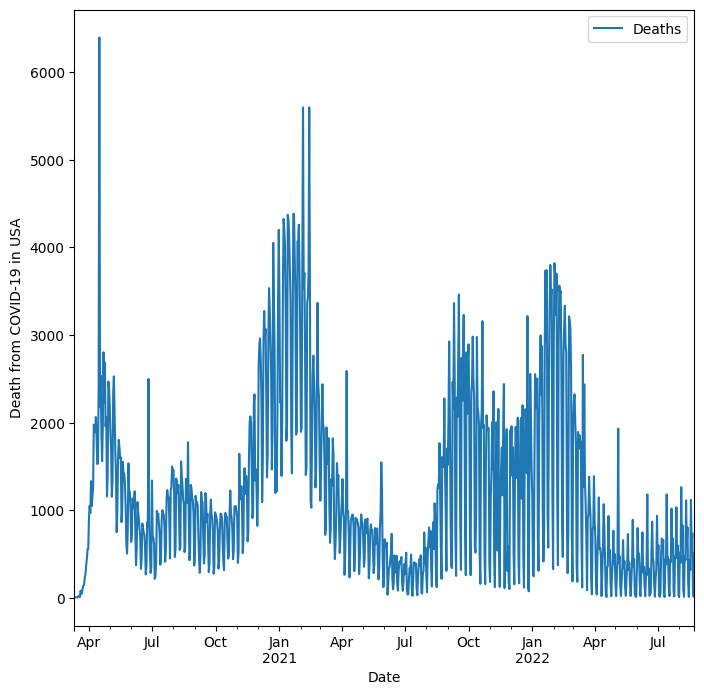

In [ ]:
#df = dataframe[dataframe['Deaths'] > 0]
#df = df['Deaths']
#df = df.dropna(axis=0,how='any')
#df = pd.DataFrame(df)
df = dataframe[::-1]
df_validation = df[int(len(df)*0.8):]
df = pd.DataFrame(df[:int(len(df)*0.8)])
df.plot(figsize(8,8))
plt.ylabel(f'{"Death from COVID-19 in USA"}') 

In [ ]:
df.describe()

Deaths
count   896.000000
mean   1196.108259
std    1019.949372
min       4.000000
25%     430.750000
50%     912.500000
75%    1719.000000
max    6396.000000

In [ ]:
#Как избавиться от аномалий: установить порог для максимального значения признака и для минимального . Иначе - приравнять значение к максимальному и минимальному порогу

Q_1 = {} #объявляем словари для минимального и максимального значения
Q_3 = {}
for elem in df.describe().columns:
  Q_1[elem] = df.describe().iloc[4][elem] #записываем в словарь значения первого квартиля
  Q_3[elem] = df.describe().iloc[6][elem] #записываем в словарь значения третьего квартиля
print(Q_1["Deaths"], Q_3["Deaths"])
for index, row in df.iterrows():
  if row["Deaths"] > 2 * Q_3["Deaths"]:
    df.loc[index, "Deaths"] = int(np.random.uniform(0.75 * Q_3["Deaths"], 1.5 * Q_3["Deaths"]))
  #elif row["Deaths"] < 0.5 * Q_1["Deaths"]:
  #  df.loc[index, "Deaths"] = int(np.random.uniform(0.75 * Q_1["Deaths"], 1.5 * Q_1["Deaths"]))


430.75 1719.0


In [ ]:
"""
i = 0
for index, row in df.iterrows():
  try:
    if row["Deaths"] > 1.5 * df.loc[index, "Deaths"] or row["Deaths"] < 1/2 * df.loc[index - 1, "Deaths"]:
      df.loc[index, "Deaths"] = int(np.sum(df["Deaths"][index-3:index].values)/3)
  except:
    pass
  i += 1
"""

'\ni = 0\nfor index, row in df.iterrows():\n  try:\n    if row["Deaths"] > 1.5 * df.loc[index, "Deaths"] or row["Deaths"] < 1/2 * df.loc[index - 1, "Deaths"]:\n      df.loc[index, "Deaths"] = int(np.sum(df["Deaths"][index-3:index].values)/3)\n  except:\n    pass\n  i += 1\n'

Text(0, 0.5, 'Death from COVID-19 in USA')

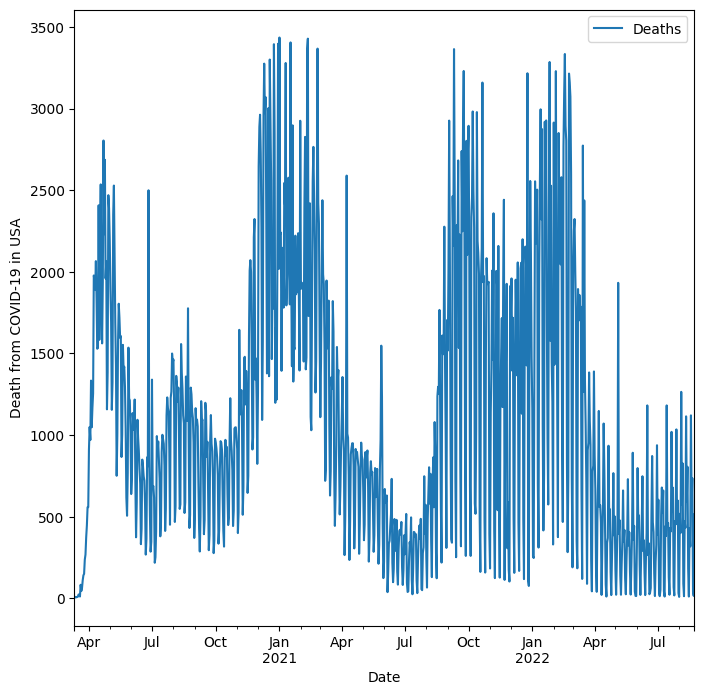

In [ ]:
df.plot(figsize(8,8))
plt.ylabel(f'{"Death from COVID-19 in USA"}') 

Вычисляем критерий Дики-Фуллера(методика, используемая для проверки временных рядов на стационарность)
Для этого используется встроенная в библиотеку statsmodels функция, которая принимает на вход временной ряд, и возвращает:
* adf (float) — тестовая статистика
* pvalue (float) — приблизительное p-value
* usedlag (int) – Количество использованных лагов, по умолчанию рассчитывается по формуле $12(nobs/100)^{1/4}$
* nobs ( int ) — количество наблюдений, используемых для регрессии ADF и расчета критических значений.
* критические значения (dict) — критические значения для тестовой статистики на уровнях 1 %, 5 % и 10 %. На основе Маккиннон (2010)
* icbest ( float ) — максимальный информационный критерий, если autolag не None.
----
Нулевая гипотеза дополненного Дики-Фуллера заключается в том,что существует единичный корень,с альтернативой,что нет единичного корня.Если значение p выше критического размера,то мы не можем отвергнуть,что существует единичный корень.


In [ ]:
adfuller = sm.tsa.stattools.adfuller(df.Deaths)
lags_count = adfuller[2]
print(adfuller, lags_count)

(-3.010118220122766, 0.03396022936490295, 21, 874, {'1%': -3.437854130362047, '5%': -2.8648525821630173, '10%': -2.5685338603647714}, 12943.298002171714) 21


Проверка стационарности и STL-декомпозиция ряда:

Стационарность – свойство, при котором статистические характеристики ряда не меняются со временем. Иными словами, если временной ряд является стационарным, то его средняя, дисперсия и ковариация не зависят от времени или местоположения в ряде. 

STL-декомпозиция – (Seasonal and Trend decomposition using Loess) метод разложения временных рядов на три компоненты: 
- сезонную(включает в себя систематические повторяющиеся изменения значений временного ряда);
- трендовую(отображает общее направление изменения значений ряда в течение его существования);
- остаточную(описывает случайные или нежелательные изменения значения ряда)
----
На основании декомпозиции данных можно сделать ряд утверждений:

1. Во временном ряде присутствует дисперсия $\rightarrow$ стабилизируем её методом Кокса-Бокса в дальнейшем
2. Тренд ненулевой, следовательно, ряд уже нельзя считать стационарным на текущем этапе
3. Частота пиков на графике сезонности даёт представление о том, сколько времени нужно для того, чтобы цикл повторился. Ввиду того, что на графике сезонности на 4 месяца в среднем приходистя по 13 пиков, можно сделать вывод об их периоде: $\frac{120}{13} = 9.23$
4. На графике остатков нельзя выявить чёткой структуры, следовательно, влияние белого шума на сами значения временного ряда мало

Критерий Дики-Фуллера: p=0.033960


<Figure size 1500x1000 with 0 Axes>

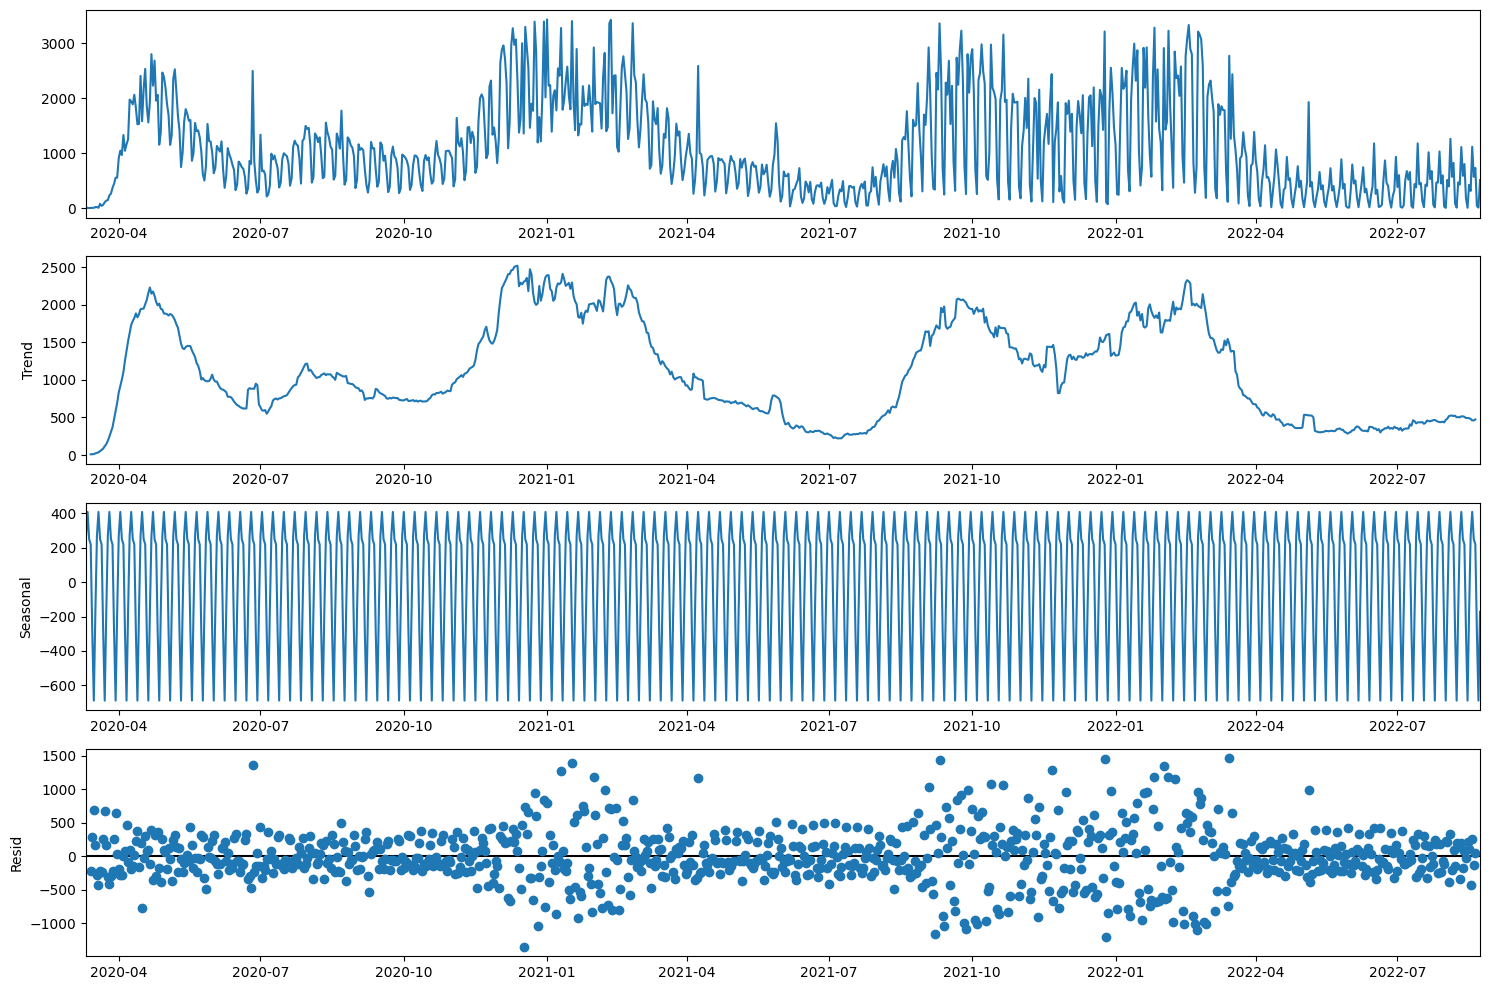

In [ ]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(pd.DataFrame(df['Deaths'])).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.Deaths)[1])

### Стабилизация дисперсии

In [ ]:
df

Deaths
Date              
2020-03-11       6
2020-03-12       8
2020-03-13       4
2020-03-14       7
2020-03-15       7
...            ...
2022-08-19     573
2022-08-20     735
2022-08-21      40
2022-08-22      14
2022-08-23     513

[896 rows x 1 columns]

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Преобразование Бокса-Кокса представляет из себя математическую процедуу преобразования данных, которая используется для стабилизации дисперсии и нормализации распределения данных

Здесь следует обратить внимание на значение переменной $lmbda$ — это значение максимизирует функцию логарифмического правдоподобия

Оптимальный параметр преобразования Бокса-Кокса: 0.436226
Критерий Дики-Фуллера: p=0.052775


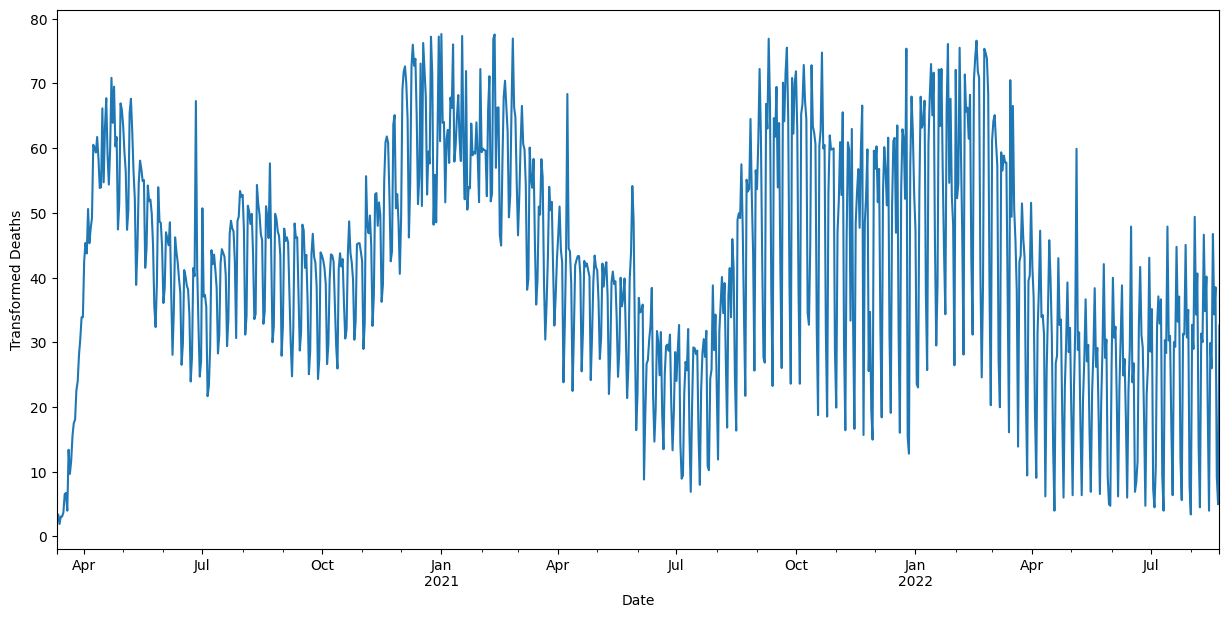

In [ ]:
df['Deaths_box'], lmbda = stats.boxcox(df.Deaths) 
df.Deaths_box.plot(figsize=(15,7))
plt.ylabel(u'Transformed Deaths')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.Deaths_box)[1])

In [ ]:
df

Deaths  Deaths_box
Date                          
2020-03-11       6    2.716463
2020-03-12       8    3.386190
2020-03-13       4    1.904453
2020-03-14       7    3.064863
2020-03-15       7    3.064863
...            ...         ...
2022-08-19     573   34.306420
2022-08-20     735   38.505458
2022-08-21      40    9.166659
2022-08-22      14    4.956295
2022-08-23     513   32.582422

[896 rows x 2 columns]

### Приведение временного ряда в состояние стационарности

Так как в данных имеется тренд, то необходимо продифференцировать временной ряд, и провести на результате STL-декомпозицию, на основании которой можно будет делать выводы о (не)стационарности полученного временного ряда. Если ряд не будет стационарным, то повторяем дифференцирование.

Выдвигаем гипотезу $H_0$ с уровнем значимости $\alpha = 0.05$ о том, что рассматриваемый ряд нестационарный(содержит единичный корень), если критерий Дики-Фуллера будет меньше заданного критического значения, то на данном уровне значимости гипотеза отвергается, иначе – принимается.

Критерий Дики-Фуллера равен 5.9282367104455655e-08 и меньше, чем критическое значение 0.05 --> гипотеза о нестационарности ОТВЕРГАЕТСЯ


<Figure size 1500x1000 with 0 Axes>

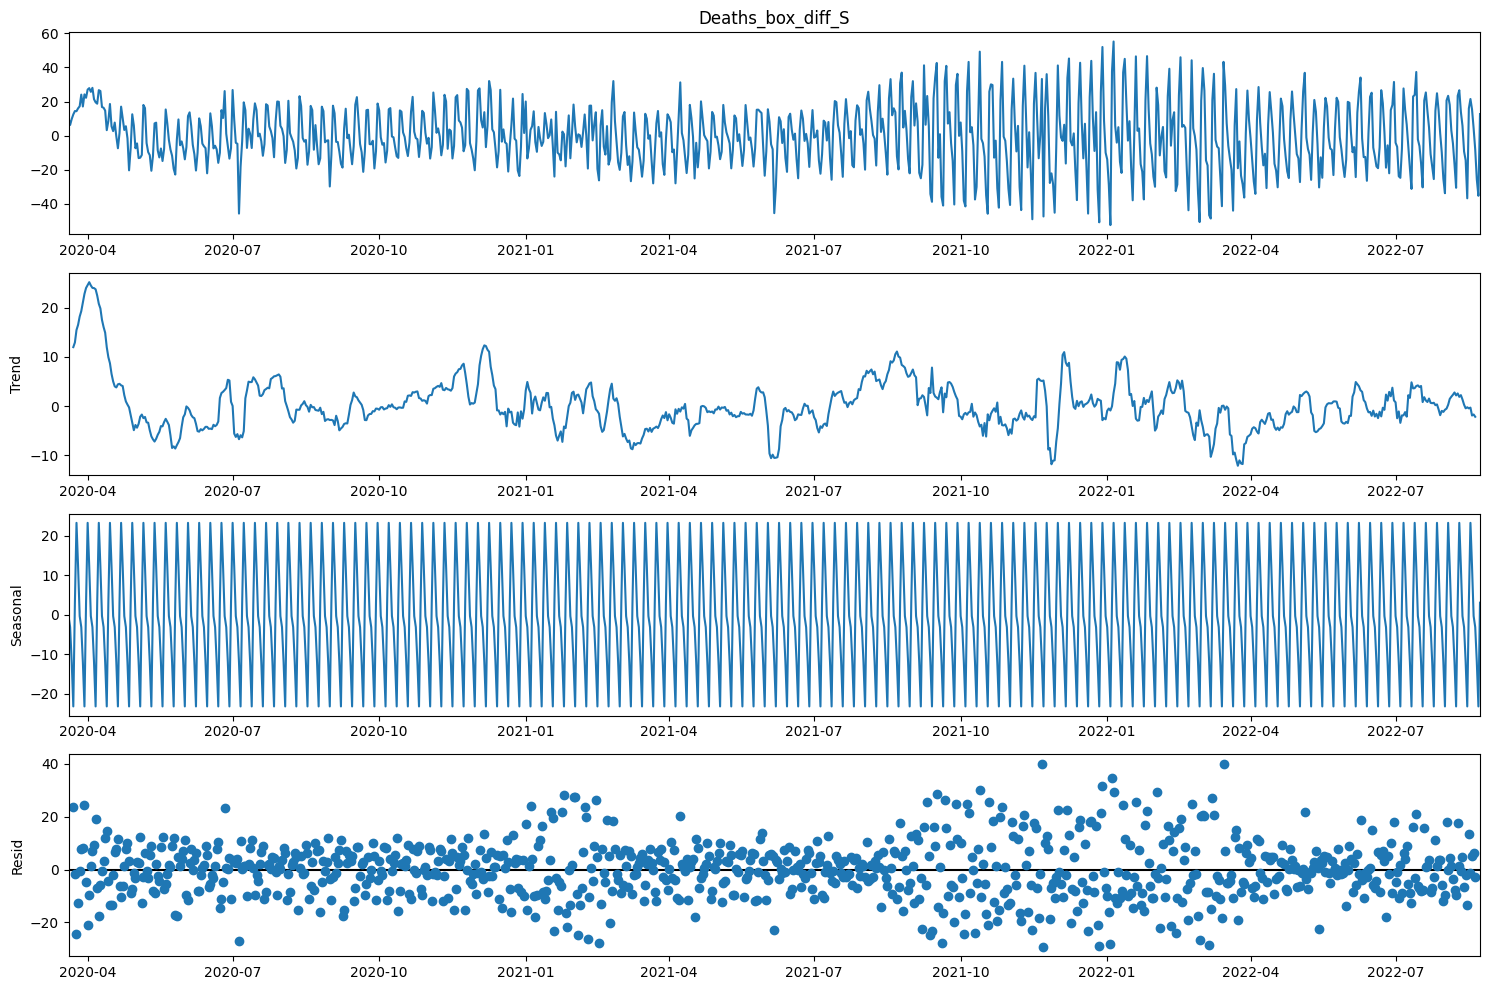

In [ ]:
plt.figure(figsize(15,10))
df['Deaths_box_diff_S'] = df.Deaths_box - df.Deaths_box.shift(9)
sm.tsa.seasonal_decompose(df.Deaths_box_diff_S[9:]).plot()
adfuller = sm.tsa.stattools.adfuller(df.Deaths_box_diff_S[9:])[1]
if adfuller < 0.05:
  print(f"Критерий Дики-Фуллера равен {adfuller} и меньше, чем критическое значение 0.05 --> гипотеза о нестационарности ОТВЕРГАЕТСЯ")
elif adfuller > 0.05:
  print(f"Критерий Дики-Фуллера равен {adfuller} и больше, чем критическое значение 0.05 --> гипотеза о нестационарности ПРИНИМАЕТСЯ")
else:
  print(f"Критерий Дики-Фуллера равен {adfuller} и равен критическому значению 0.05 --> гипотеза о нестационарности должна быть проверена по другому критерию")

Критерий Дики-Фуллера отвергает / не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1500x1000 with 0 Axes>

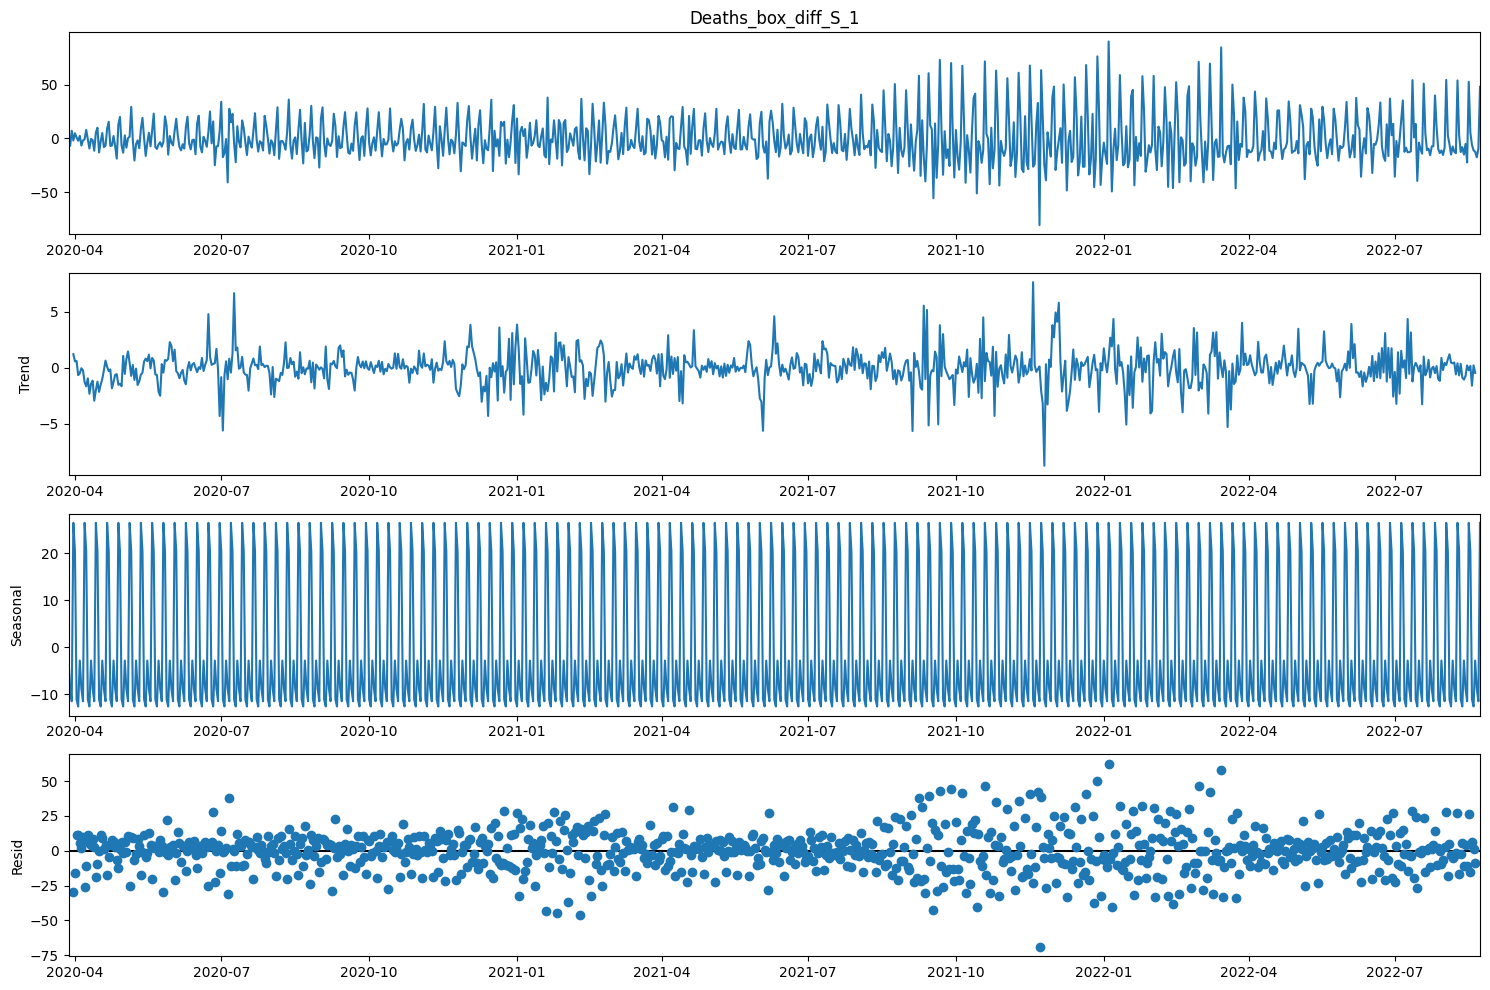

In [ ]:
plt.figure(figsize(15,10))
df['Deaths_box_diff_S_1'] = df.Deaths_box_diff_S - df.Deaths_box_diff_S.shift(1)
sm.tsa.seasonal_decompose(df.Deaths_box_diff_S_1[17:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.Deaths_box_diff_S_1[17:])[1])

d = 0, 1, D = 0, 1

$d$ — число применений обычного дифференцирования к ряду

$D$ — число применений сезонного дифференцирования к ряду

In [ ]:
df

Deaths  Deaths_box  Deaths_box_diff_S  Deaths_box_diff_S_1
Date                                                                  
2020-03-11       6    2.716463                NaN                  NaN
2020-03-12       8    3.386190                NaN                  NaN
2020-03-13       4    1.904453                NaN                  NaN
2020-03-14       7    3.064863                NaN                  NaN
2020-03-15       7    3.064863                NaN                  NaN
...            ...         ...                ...                  ...
2022-08-19     573   34.306420           4.275509           -11.121269
2022-08-20     735   38.505458          -8.114523           -12.390032
2022-08-21      40    9.166659         -25.636921           -17.522398
2022-08-22      14    4.956295         -35.200749            -9.563828
2022-08-23     513   32.582422          12.683132            47.883881

[896 rows x 4 columns]

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

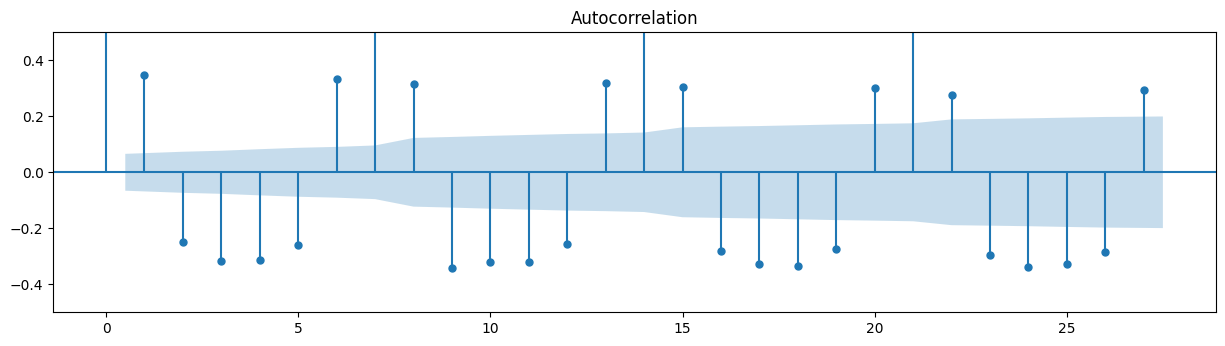

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


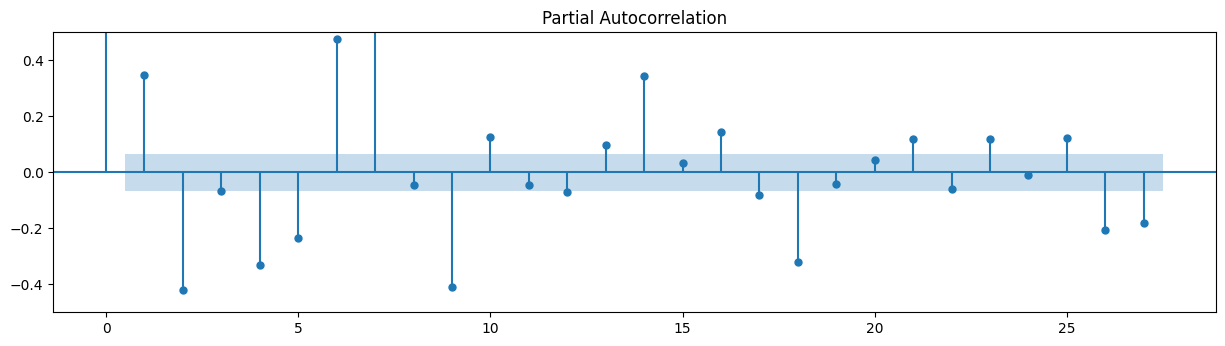

In [ ]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.Deaths_box_diff_S[10:].values.squeeze(), lags=lags_count+6, ax=ax)
plt.ylim([-0.5, 0.5])
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.Deaths_box_diff_S[10:].values.squeeze(), lags=lags_count+6, ax=ax)
plt.ylim([-0.5, 0.5])
pylab.show()

Параметры $Q, q, P, p$

Здесь 

$S$ — период

$Q \cdot S$ – номер последнего сезонного лага, при котором
автокорреляция значима.

$Q$ – номер последнего значимого сезонного лага функции автокорелляции 

$q$ – номер последнего несезонного лага, при котором автокорреляция значима

$P \cdot S$ – номер последнего сезонного лага, при котором частичная автокорреляция значима

$P$ – начальное приближение

$p$ — номер последнего несезонного лага, при котором частичная автокорреляция значима.



In [ ]:
#мои параметры
#QS = 27, 
ps = range(0, 6) 
d = 1
qs = range(0, 6) 
Ps = range(0, 2)
D = 1
Qs = range(0, 2)

In [ ]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

144

In [ ]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df.Deaths_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 22min 16s, sys: 17min 33s, total: 39min 49s
Wall time: 23min 11s


In [ ]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True)[:25])

       parameters          aic
141  (5, 5, 0, 1)  6031.616159
143  (5, 5, 1, 1)  6061.295083
139  (5, 4, 1, 1)  6075.308510
137  (5, 4, 0, 1)  6095.527283
119  (4, 5, 1, 1)  6206.628906
131  (5, 2, 1, 1)  6222.644158
133  (5, 3, 0, 1)  6227.880585
129  (5, 2, 0, 1)  6229.012355
117  (4, 5, 0, 1)  6230.087174
135  (5, 3, 1, 1)  6245.379318
142  (5, 5, 1, 0)  6261.149955
111  (4, 3, 1, 1)  6280.673121
109  (4, 3, 0, 1)  6283.901241
95   (3, 5, 1, 1)  6302.036153
113  (4, 4, 0, 1)  6304.321040
71   (2, 5, 1, 1)  6304.909406
69   (2, 5, 0, 1)  6305.124356
93   (3, 5, 0, 1)  6306.967416
87   (3, 3, 1, 1)  6318.231837
63   (2, 3, 1, 1)  6342.402666
138  (5, 4, 1, 0)  6347.717609
91   (3, 4, 1, 1)  6354.850592
115  (4, 4, 1, 1)  6357.805777
85   (3, 3, 0, 1)  6369.156335
107  (4, 2, 1, 1)  6372.504449


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Лучшую модель подбираем по критерию Акаике:

Он основан на информационной энтропии, которая описывает, насколько хорошо данная модель соответствует данным.

Цель критерия Акаике - выбрать модель, которая наилучшим образом описывает данные и является наиболее простой, то есть с минимальным числом параметров. Критерий Акаике определяется как $AIC = 2k - 2ln(L)$, где $k$ - число параметров в модели, а $ln(L)$ - логарифм правдоподобия модели.

Чем меньше значение критерия AIC, тем лучше модель. Это означает, что при сравнении моделей с разным числом параметров, модель с меньшим значением AIC предпочтительнее.

Однако следует учитывать, что возможны случаи, когда критерий Акаике мал, но фактическое качество модели ужасное ввиду недостатка данных и/или переобучения

In [ ]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                           Deaths_box   No. Observations:                  896
Model:             SARIMAX(5, 1, 5)x(0, 1, [1], 12)   Log Likelihood               -3003.808
Date:                              Fri, 07 Apr 2023   AIC                           6031.616
Time:                                      03:15:10   BIC                           6089.016
Sample:                                  03-11-2020   HQIC                          6053.563
                                       - 08-23-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3375      0.037      9.013      0.000       0.264       0.411
ar.L2         -1.06

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Была получена модели SARIMAX(p, d, q), её коэффициенты приведены ниже

In [ ]:
best_model.params

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ar.L1        0.337461
ar.L2       -1.068765
ar.L3        0.141700
ar.L4       -0.621188
ar.L5       -0.445953
ma.L1       -1.183172
ma.L2        1.523162
ma.L3       -1.278792
ma.L4        1.030789
ma.L5       -0.371609
ma.S.L12    -0.965370
sigma2      48.225961
dtype: float64

Остатки и функция автокорелляции:

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Критерий Дики-Фуллера: p=0.000005


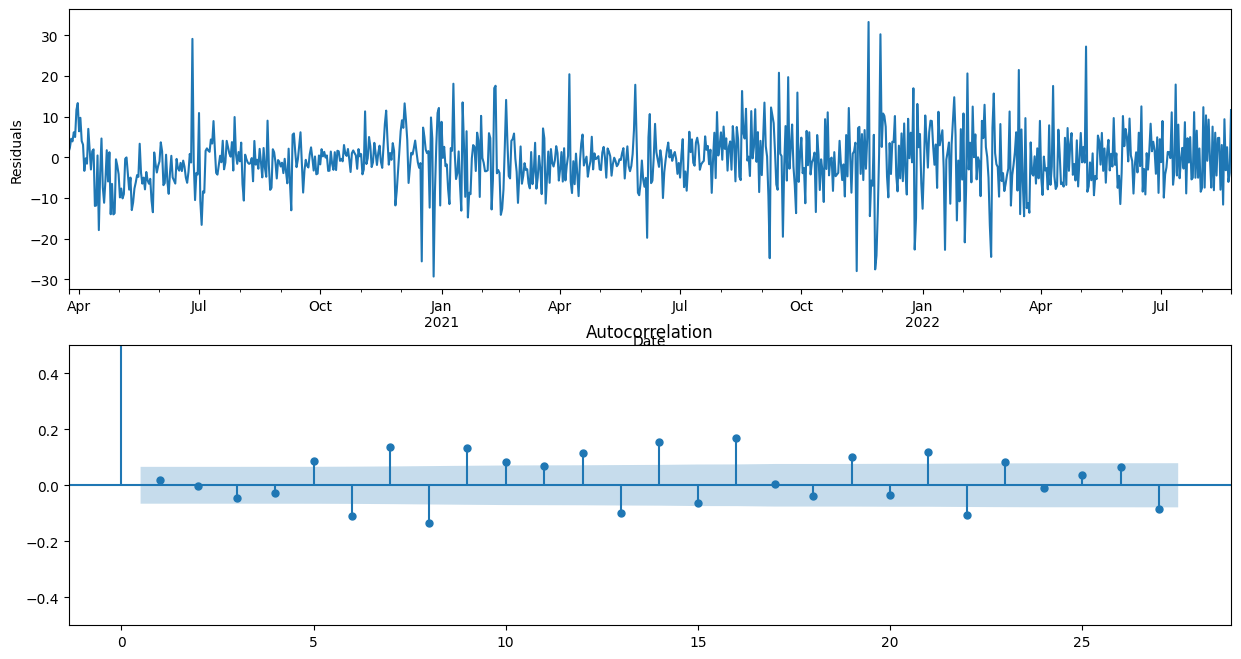

In [ ]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[9:].values.squeeze(), lags=27, ax=ax)
plt.ylim([-0.5, 0.5])

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[9:])[1])

## Прогноз

###На всех обучающих данных

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


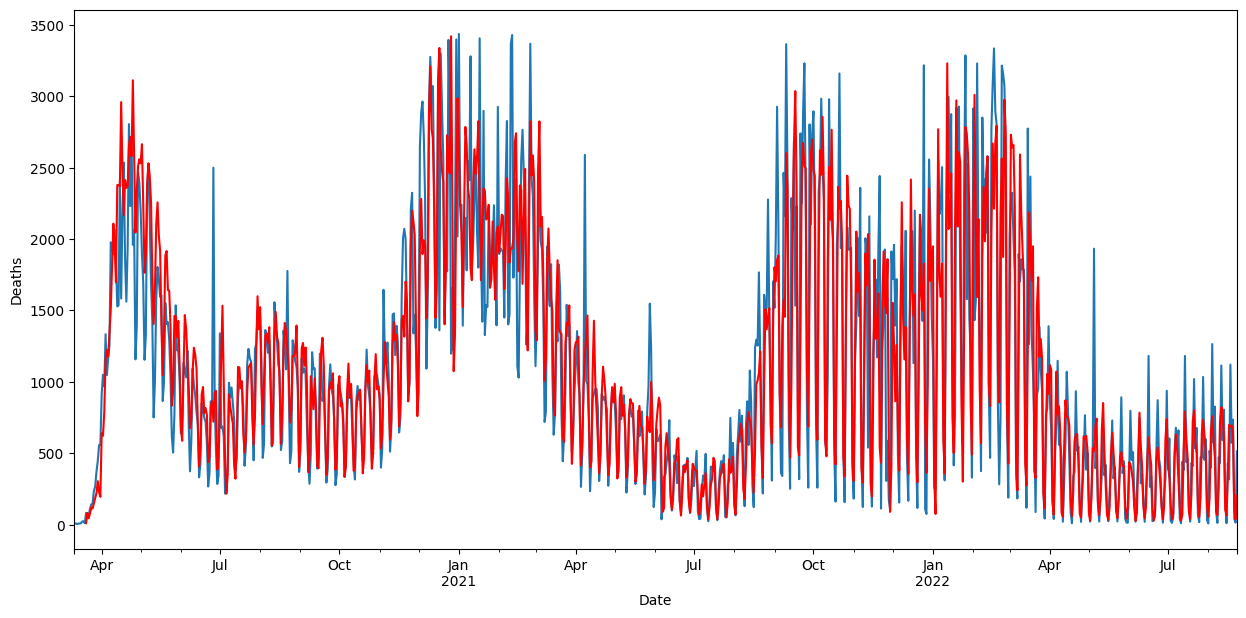

In [ ]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,7))
df.Deaths.plot()
df.model[9:].plot(color='r')
plt.ylabel('Deaths')
plt.show()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


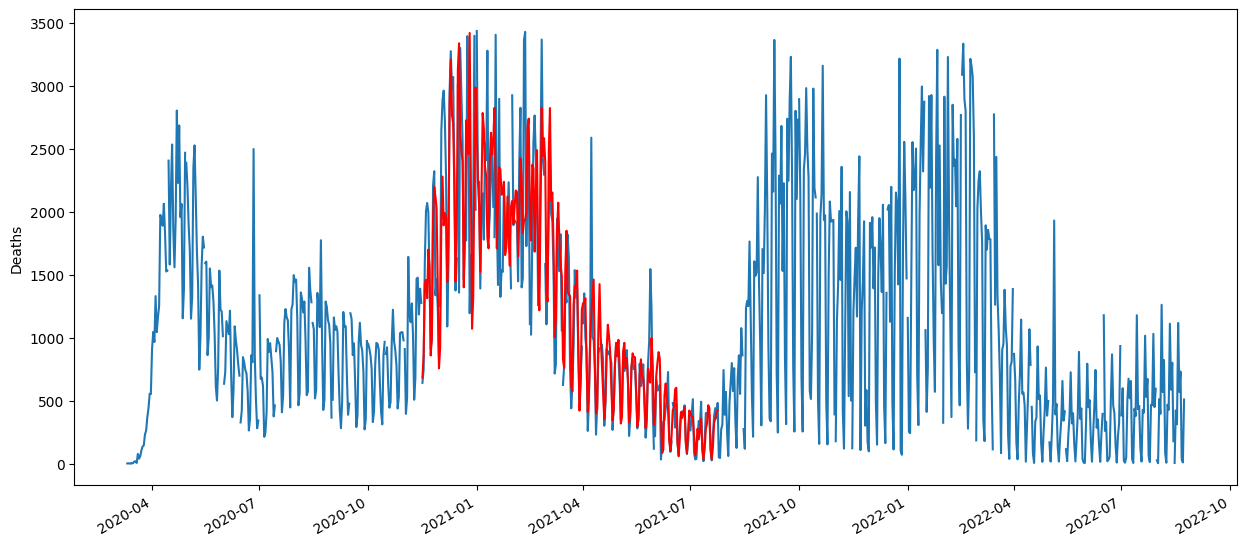

In [ ]:
df2 = df[['Deaths']]
start_date = df2.index[0]
end_date = df2.index[-1]
months = pd.date_range(start_date, end_date, freq='SM')
future = pd.DataFrame(index=months, columns=df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=250, end=500), lmbda)
plt.figure(figsize=(15,7))
df2.Deaths.plot()
df2.forecast.plot(color='r')
plt.ylabel('Deaths')
plt.show()

In [ ]:
df2.dropna()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Deaths     forecast
2020-11-16    645   687.072354
2020-11-17    751   863.188149
2020-11-18   1603  1435.357738
2020-11-19   2007  1461.273700
2020-11-20   2071  1316.600389
...           ...          ...
2021-07-20    237   139.111942
2021-07-21    380   329.465321
2021-07-22    445   362.194465
2021-07-23    364   412.619683
2021-07-24    486   426.615461

[251 rows x 2 columns]

###На валидационной части данных

In [ ]:
df_validation

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Deaths
Date              
2022-08-24     334
2022-08-25    1133
2022-08-26     562
2022-08-27     732
2022-08-28     281
...            ...
2023-04-01      29
2023-04-02     225
2023-04-03      33
2023-04-04     312
2023-04-05     632

[225 rows x 1 columns]

In [ ]:
start_date = df_validation.index[0]
end_date = df_validation.index[-1]
months = pd.date_range(start_date, end_date, freq='SM')
future = pd.DataFrame(index=months, columns=df_validation.columns)
df_val = pd.concat([df_validation, future])
df_val['forecast'] = invboxcox(best_model.predict(start=start_date, end=end_date), lmbda)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


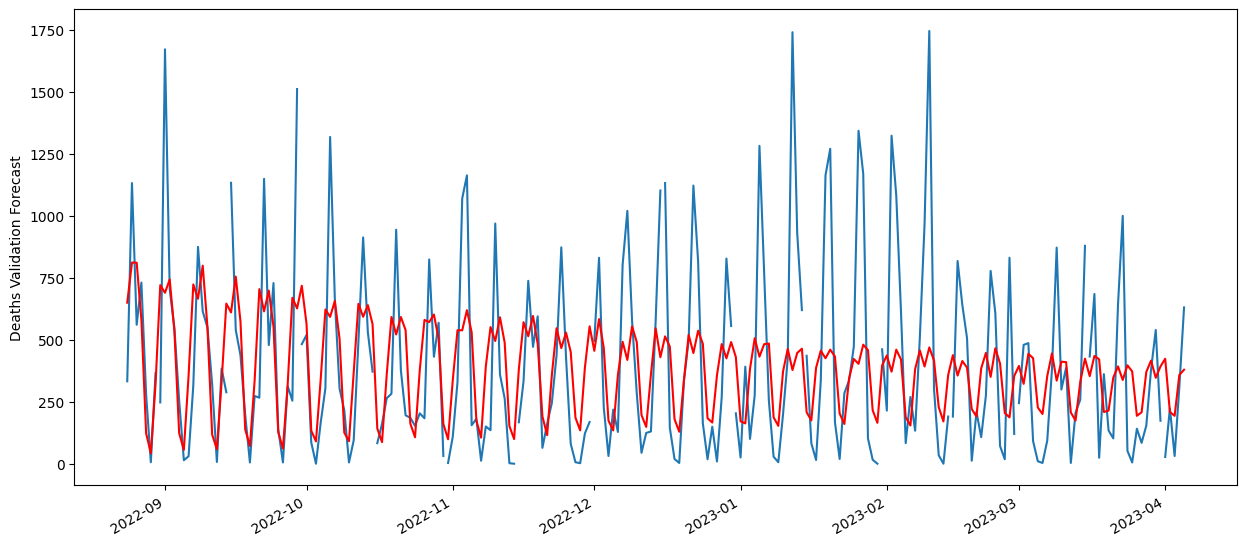

In [ ]:
plt.figure(figsize=(15,7))
df_val.Deaths.plot()
df_val.forecast.plot(color='r')
plt.ylabel('Deaths Validation Forecast')
plt.show()

In [ ]:
df_validation = df_validation.dropna()
df_validation

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Deaths
Date              
2022-08-24     334
2022-08-25    1133
2022-08-26     562
2022-08-27     732
2022-08-28     281
...            ...
2023-04-01      29
2023-04-02     225
2023-04-03      33
2023-04-04     312
2023-04-05     632

[225 rows x 1 columns]